0. Libraries used:

In [1]:
# Data manipulation and preprocessing
import yfinance as yf  # For downloading stock data
import pandas as pd  # For handling data in DataFrame
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For plotting graphs
from sklearn.preprocessing import MinMaxScaler  # For data normalization
from sklearn.metrics import mean_squared_error  # For model evaluation

# Deep learning and model building
from tensorflow.keras.models import Sequential  # For building the model
from tensorflow.keras.layers import LSTM, Conv1D, Dropout, Dense  # For model layers
from tensorflow.keras.optimizers import Adam  # For optimizer

1. Modify Data Preprocessing:

In [2]:
# Fetch AAPL stock data (5 years of daily data)
data = yf.download("AAPL", period="5y", interval="1d")

# Extract 'High', 'Low', 'Close', and 'Open' columns
df = data[['High', 'Low', 'Close', 'Open']]

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# Convert back to DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=['High', 'Low', 'Close', 'Open'], index=df.index)

# Display the first few rows
print(scaled_df.head())

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

                High       Low     Close      Open
Date                                              
2020-03-02  0.086616  0.076796  0.088430  0.064936
2020-03-03  0.089656  0.086326  0.077157  0.090563
2020-03-04  0.088943  0.094972  0.093099  0.081901
2020-03-05  0.084371  0.092943  0.081433  0.080799
2020-03-06  0.074005  0.080936  0.076812  0.064601


2. Create Sequences for Prediction:

In [3]:
# Function to create sequences for time series prediction
def create_sequences(data, lookback=30):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i, :2])  # Use 'High' and 'Low' for prediction
        y.append(data[i, 2:4])  # Target is 'Close' and 'Open' for predicting next day's values
    return np.array(X), np.array(y)

lookback = 30  # Using 30 days to predict next day's 'Close' and 'Open' value
X, y = create_sequences(scaled_df.values, lookback=lookback)

# Train-test split of 80-20
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape for LSTM input (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(981, 30, 2) (981, 2) (246, 30, 2) (246, 2)


3. Build and Train the Model:

In [4]:
# Build the model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))  # 1D Convolutional Layer to extract local features from the input sequence
model.add(Dropout(0.2)) # Dropout layer to prevent overfitting by randomly setting 20% of input units to 0
model.add(LSTM(units=50, return_sequences=False, activation='tanh')) # LSTM Layer to capture temporal dependencies in the sequence
model.add(Dense(units=2))  # Dense layer to output the predicted 'Close' and 'Open' prices
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error') # Compile the model with Adam optimizer and Mean Squared Error loss function

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), verbose=1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - loss: 0.1622 - val_loss: 0.0047
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0062 - val_loss: 0.0244
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0027 - val_loss: 0.0114
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0014 - val_loss: 0.0064
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0013 - val_loss: 0.0047
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0012 - val_loss: 0.0049
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0011 - val_loss: 0.0047
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0010 - val_loss: 0.0044
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0011 - val_loss: 0.0054
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0011 - val_loss: 0.0054
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0011 - val_loss: 0.0048
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0

4. Make Predictions and Inverse Transform:

In [5]:
# Predict on the test data
y_pred = model.predict(X_test)

# Inverse transform to get the actual values
# Inverse transform the predictions and actual values
y_pred_actual = scaler.inverse_transform(np.concatenate((y_pred, y_pred), axis=1))[:, :2]  # Only the 'Close' and 'Open' values
y_test_actual = scaler.inverse_transform(np.concatenate((y_test, y_test), axis=1))[:, :2]  # Only the 'Close' and 'Open' values

# Display the predicted vs actual 'Close' and 'Open' prices
print(f"Predicted Close and Open prices: {y_pred_actual[:5]}")
print(f"Actual Close and Open prices: {y_test_actual[:5]}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
Predicted Close and Open prices: [[180.62152 176.8855 ]
 [179.46361 175.72244]
 [178.73932 175.04019]
 [178.58803 174.9384 ]
 [178.33595 174.70062]]
Actual Close and Open prices: [[169.25066548 166.38320262]
 [170.97318888 166.23157165]
 [172.98444046 170.21489703]
 [173.46234167 170.42718014]
 [171.37145516 170.04302985]]


5. Visualize predicted vs. actual stock prices.

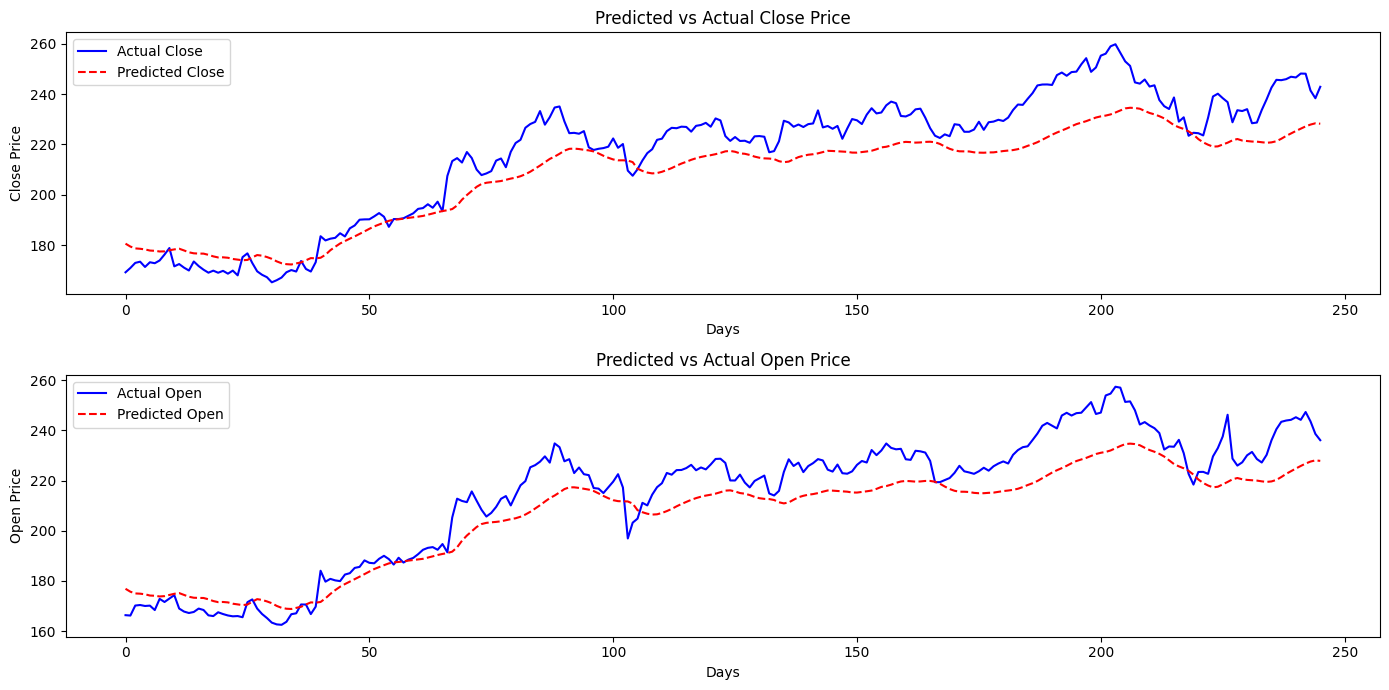

In [6]:
# Plotting the predicted vs actual Close and Open prices
plt.figure(figsize=(14, 7))

# Plot for Close prices
plt.subplot(2, 1, 1)
plt.plot(y_test_actual[:, 0], label='Actual Close', color='blue')
plt.plot(y_pred_actual[:, 0], label='Predicted Close', color='red', linestyle='--')
plt.title('Predicted vs Actual Close Price')
plt.xlabel('Days')
plt.ylabel('Close Price')
plt.legend()

# Plot for Open prices
plt.subplot(2, 1, 2)
plt.plot(y_test_actual[:, 1], label='Actual Open', color='blue')
plt.plot(y_pred_actual[:, 1], label='Predicted Open', color='red', linestyle='--')
plt.title('Predicted vs Actual Open Price')
plt.xlabel('Days')
plt.ylabel('Open Price')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

6. Evaluation (MSE, RMSE, Percentage Error):

In [7]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Calculate MSE and RMSE
mse = mean_squared_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mse)

# Calculate percentage error
percentage_error_close = np.mean(np.abs((y_test_actual[:, 0] - y_pred_actual[:, 0]) / y_test_actual[:, 0])) * 100
percentage_error_open = np.mean(np.abs((y_test_actual[:, 1] - y_pred_actual[:, 1]) / y_test_actual[:, 1])) * 100

# Print the error metrics
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Percentage Error for Close: {percentage_error_close:.2f}%")
print(f"Percentage Error for Open: {percentage_error_open:.2f}%")

Mean Squared Error (MSE): 137.0375
Root Mean Squared Error (RMSE): 11.7063
Percentage Error for Close: 4.54%
Percentage Error for Open: 4.25%


7. Fine-tuning & Optimization

In [8]:
# Initialize variables to track the best results
best_mse = float('inf')  # Set initial best MSE to a very large number
best_rmse = float('inf')  # Set initial best RMSE to a very large number
best_params = {}

# New hyperparameters as per the request
epochs = [25, 50, 100]
lstm_units = [32, 100, 200]
filters = [32, 64, 128]
lookbacks = [7, 30, 120]

for epoch in epochs:
    for lstm_unit in lstm_units:
        for filter_size in filters:
            for lookback in lookbacks:
                print(f"Training with epoch={epoch}, lstm_units={lstm_unit}, filters={filter_size}, lookback={lookback}")

                # Data preprocessing with the current lookback value
                X, y = create_sequences(scaled_df.values, lookback=lookback)

                # Train-test split
                train_size = int(len(X) * 0.8)
                X_train, X_test = X[:train_size], X[train_size:]
                y_train, y_test = y[:train_size], y[train_size:]

                # Reshape for LSTM input
                X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
                X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

                # Build the model with current hyperparameters
                model = Sequential()
                model.add(Conv1D(filters=filter_size, kernel_size=3, strides=1, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
                model.add(Dropout(0.35))  # Updated dropout to 0.35
                model.add(LSTM(units=lstm_unit, return_sequences=False, activation='tanh'))
                model.add(Dense(units=2))  # Output for Close and Open prices
                model.compile(optimizer=Adam(), loss='mean_squared_error')

                # Train the model
                history = model.fit(X_train, y_train, epochs=epoch, batch_size=32, validation_data=(X_test, y_test), verbose=0)

                # Get final validation loss
                val_loss = history.history['val_loss'][-1]

                # Calculate MSE and RMSE
                y_pred = model.predict(X_test)
                mse = mean_squared_error(y_test, y_pred)
                rmse = np.sqrt(mse)

                # Print the results for this iteration
                print(f"Training Loss: {history.history['loss'][-1]:.5f}")
                print(f"Validation Loss: {val_loss:.5f}")
                print(f"MSE: {mse:.5f}, RMSE: {rmse:.5f}")
                print('-' * 50)

                # Track the best result
                if mse < best_mse:
                    best_mse = mse
                    best_rmse = rmse
                    best_params = {
                        'epoch': epoch,
                        'lstm_units': lstm_unit,
                        'filters': filter_size,
                        'lookback': lookback
                    }

# Print the best combination with the lowest MSE and RMSE
print("Best Hyperparameters:")
print(f"Epochs: {best_params['epoch']}")
print(f"LSTM Units: {best_params['lstm_units']}")
print(f"Filters: {best_params['filters']}")
print(f"Lookback: {best_params['lookback']}")
print(f"Lowest MSE: {best_mse:.5f}")
print(f"Lowest RMSE: {best_rmse:.5f}")

# Calculate Mean Actual Price of Close and Open Prices
mean_actual_price = np.mean(y_test)

# Compute Percentage RMSE
percentage_rmse = (best_rmse / mean_actual_price) * 100

# Display the result
print(f"Lowest RMSE: {best_rmse:.5f}")
print(f"Percentage RMSE: {percentage_rmse:.2f}%")

Training with epoch=25, lstm_units=32, filters=32, lookback=7


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Training Loss: 0.00126
Validation Loss: 0.00884
MSE: 0.00884, RMSE: 0.09403
--------------------------------------------------
Training with epoch=25, lstm_units=32, filters=32, lookback=30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Training Loss: 0.00102
Validation Loss: 0.00822
MSE: 0.00822, RMSE: 0.09067
--------------------------------------------------
Training with epoch=25, lstm_units=32, filters=32, lookback=120


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
Training Loss: 0.00137
Validation Loss: 0.00572
MSE: 0.00572, RMSE: 0.07566
--------------------------------------------------
Training with epoch=25, lstm_units=32, filters=64, lookback=7


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Training Loss: 0.00097
Validation Loss: 0.00540
MSE: 0.00540, RMSE: 0.07345
--------------------------------------------------
Training with epoch=25, lstm_units=32, filters=64, lookback=30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Training Loss: 0.00081
Validation Loss: 0.00383
MSE: 0.00383, RMSE: 0.06191
--------------------------------------------------
Training with epoch=25, lstm_units=32, filters=64, lookback=120


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Training Loss: 0.00103
Validation Loss: 0.00226
MSE: 0.00226, RMSE: 0.04756
--------------------------------------------------
Training with epoch=25, lstm_units=32, filters=128, lookback=7


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Training Loss: 0.00076
Validation Loss: 0.00531
MSE: 0.00531, RMSE: 0.07286
--------------------------------------------------
Training with epoch=25, lstm_units=32, filters=128, lookback=30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Training Loss: 0.00074
Validation Loss: 0.00426
MSE: 0.00426, RMSE: 0.06526
--------------------------------------------------
Training with epoch=25, lstm_units=32, filters=128, lookback=120


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Training Loss: 0.00078
Validation Loss: 0.00228
MSE: 0.00228, RMSE: 0.04775
--------------------------------------------------
Training with epoch=25, lstm_units=100, filters=32, lookback=7


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Training Loss: 0.00122
Validation Loss: 0.00766
MSE: 0.00766, RMSE: 0.08754
--------------------------------------------------
Training with epoch=25, lstm_units=100, filters=32, lookback=30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Training Loss: 0.00075
Validation Loss: 0.01009
MSE: 0.01009, RMSE: 0.10044
--------------------------------------------------
Training with epoch=25, lstm_units=100, filters=32, lookback=120


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Training Loss: 0.00116
Validation Loss: 0.00490
MSE: 0.00490, RMSE: 0.06999
--------------------------------------------------
Training with epoch=25, lstm_units=100, filters=64, lookback=7


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Training Loss: 0.00091
Validation Loss: 0.00643
MSE: 0.00643, RMSE: 0.08019
--------------------------------------------------
Training with epoch=25, lstm_units=100, filters=64, lookback=30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Training Loss: 0.00075
Validation Loss: 0.00370
MSE: 0.00370, RMSE: 0.06079
--------------------------------------------------
Training with epoch=25, lstm_units=100, filters=64, lookback=120


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Training Loss: 0.00074
Validation Loss: 0.00186
MSE: 0.00186, RMSE: 0.04317
--------------------------------------------------
Training with epoch=25, lstm_units=100, filters=128, lookback=7


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Training Loss: 0.00067
Validation Loss: 0.00388
MSE: 0.00388, RMSE: 0.06226
--------------------------------------------------
Training with epoch=25, lstm_units=100, filters=128, lookback=30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Training Loss: 0.00067
Validation Loss: 0.00297
MSE: 0.00297, RMSE: 0.05449
--------------------------------------------------
Training with epoch=25, lstm_units=100, filters=128, lookback=120


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Training Loss: 0.00066
Validation Loss: 0.00190
MSE: 0.00190, RMSE: 0.04363
--------------------------------------------------
Training with epoch=25, lstm_units=200, filters=32, lookback=7


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Training Loss: 0.00091
Validation Loss: 0.00479
MSE: 0.00479, RMSE: 0.06919
--------------------------------------------------
Training with epoch=25, lstm_units=200, filters=32, lookback=30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Training Loss: 0.00085
Validation Loss: 0.00545
MSE: 0.00545, RMSE: 0.07383
--------------------------------------------------
Training with epoch=25, lstm_units=200, filters=32, lookback=120


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Training Loss: 0.00098
Validation Loss: 0.00243
MSE: 0.00243, RMSE: 0.04926
--------------------------------------------------
Training with epoch=25, lstm_units=200, filters=64, lookback=7


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Training Loss: 0.00076
Validation Loss: 0.00314
MSE: 0.00314, RMSE: 0.05606
--------------------------------------------------
Training with epoch=25, lstm_units=200, filters=64, lookback=30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Training Loss: 0.00071
Validation Loss: 0.00456
MSE: 0.00456, RMSE: 0.06751
--------------------------------------------------
Training with epoch=25, lstm_units=200, filters=64, lookback=120


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Training Loss: 0.00093
Validation Loss: 0.00277
MSE: 0.00277, RMSE: 0.05259
--------------------------------------------------
Training with epoch=25, lstm_units=200, filters=128, lookback=7


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Training Loss: 0.00067
Validation Loss: 0.00297
MSE: 0.00297, RMSE: 0.05451
--------------------------------------------------
Training with epoch=25, lstm_units=200, filters=128, lookback=30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Training Loss: 0.00060
Validation Loss: 0.00253
MSE: 0.00253, RMSE: 0.05026
--------------------------------------------------
Training with epoch=25, lstm_units=200, filters=128, lookback=120


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step
Training Loss: 0.00069
Validation Loss: 0.00278
MSE: 0.00278, RMSE: 0.05277
--------------------------------------------------
Training with epoch=50, lstm_units=32, filters=32, lookback=7


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Training Loss: 0.00105
Validation Loss: 0.00811
MSE: 0.00811, RMSE: 0.09008
--------------------------------------------------
Training with epoch=50, lstm_units=32, filters=32, lookback=30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Training Loss: 0.00083
Validation Loss: 0.00289
MSE: 0.00289, RMSE: 0.05379
--------------------------------------------------
Training with epoch=50, lstm_units=32, filters=32, lookback=120


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Training Loss: 0.00081
Validation Loss: 0.00227
MSE: 0.00227, RMSE: 0.04769
--------------------------------------------------
Training with epoch=50, lstm_units=32, filters=64, lookback=7


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Training Loss: 0.00070
Validation Loss: 0.00660
MSE: 0.00660, RMSE: 0.08122
--------------------------------------------------
Training with epoch=50, lstm_units=32, filters=64, lookback=30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Training Loss: 0.00068
Validation Loss: 0.00412
MSE: 0.00412, RMSE: 0.06419
--------------------------------------------------
Training with epoch=50, lstm_units=32, filters=64, lookback=120


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Training Loss: 0.00071
Validation Loss: 0.00248
MSE: 0.00248, RMSE: 0.04984
--------------------------------------------------
Training with epoch=50, lstm_units=32, filters=128, lookback=7


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Training Loss: 0.00063
Validation Loss: 0.00402
MSE: 0.00402, RMSE: 0.06342
--------------------------------------------------
Training with epoch=50, lstm_units=32, filters=128, lookback=30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Training Loss: 0.00063
Validation Loss: 0.00341
MSE: 0.00341, RMSE: 0.05839
--------------------------------------------------
Training with epoch=50, lstm_units=32, filters=128, lookback=120


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Training Loss: 0.00064
Validation Loss: 0.00171
MSE: 0.00171, RMSE: 0.04135
--------------------------------------------------
Training with epoch=50, lstm_units=100, filters=32, lookback=7


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Training Loss: 0.00096
Validation Loss: 0.00928
MSE: 0.00928, RMSE: 0.09633
--------------------------------------------------
Training with epoch=50, lstm_units=100, filters=32, lookback=30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Training Loss: 0.00083
Validation Loss: 0.00490
MSE: 0.00490, RMSE: 0.07000
--------------------------------------------------
Training with epoch=50, lstm_units=100, filters=32, lookback=120


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Training Loss: 0.00055
Validation Loss: 0.00262
MSE: 0.00262, RMSE: 0.05123
--------------------------------------------------
Training with epoch=50, lstm_units=100, filters=64, lookback=7


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Training Loss: 0.00082
Validation Loss: 0.00579
MSE: 0.00579, RMSE: 0.07610
--------------------------------------------------
Training with epoch=50, lstm_units=100, filters=64, lookback=30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Training Loss: 0.00064
Validation Loss: 0.00297
MSE: 0.00297, RMSE: 0.05453
--------------------------------------------------
Training with epoch=50, lstm_units=100, filters=64, lookback=120


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Training Loss: 0.00055
Validation Loss: 0.00207
MSE: 0.00207, RMSE: 0.04554
--------------------------------------------------
Training with epoch=50, lstm_units=100, filters=128, lookback=7


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Training Loss: 0.00039
Validation Loss: 0.00206
MSE: 0.00206, RMSE: 0.04539
--------------------------------------------------
Training with epoch=50, lstm_units=100, filters=128, lookback=30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Training Loss: 0.00046
Validation Loss: 0.00243
MSE: 0.00243, RMSE: 0.04930
--------------------------------------------------
Training with epoch=50, lstm_units=100, filters=128, lookback=120


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Training Loss: 0.00059
Validation Loss: 0.00340
MSE: 0.00340, RMSE: 0.05827
--------------------------------------------------
Training with epoch=50, lstm_units=200, filters=32, lookback=7


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Training Loss: 0.00078
Validation Loss: 0.01117
MSE: 0.01117, RMSE: 0.10567
--------------------------------------------------
Training with epoch=50, lstm_units=200, filters=32, lookback=30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Training Loss: 0.00061
Validation Loss: 0.00746
MSE: 0.00746, RMSE: 0.08638
--------------------------------------------------
Training with epoch=50, lstm_units=200, filters=32, lookback=120


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Training Loss: 0.00094
Validation Loss: 0.00194
MSE: 0.00194, RMSE: 0.04406
--------------------------------------------------
Training with epoch=50, lstm_units=200, filters=64, lookback=7


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Training Loss: 0.00082
Validation Loss: 0.00624
MSE: 0.00624, RMSE: 0.07901
--------------------------------------------------
Training with epoch=50, lstm_units=200, filters=64, lookback=30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Training Loss: 0.00062
Validation Loss: 0.00280
MSE: 0.00280, RMSE: 0.05289
--------------------------------------------------
Training with epoch=50, lstm_units=200, filters=64, lookback=120


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Training Loss: 0.00063
Validation Loss: 0.00256
MSE: 0.00256, RMSE: 0.05059
--------------------------------------------------
Training with epoch=50, lstm_units=200, filters=128, lookback=7


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Training Loss: 0.00046
Validation Loss: 0.00312
MSE: 0.00312, RMSE: 0.05588
--------------------------------------------------
Training with epoch=50, lstm_units=200, filters=128, lookback=30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Training Loss: 0.00042
Validation Loss: 0.00131
MSE: 0.00131, RMSE: 0.03617
--------------------------------------------------
Training with epoch=50, lstm_units=200, filters=128, lookback=120


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Training Loss: 0.00051
Validation Loss: 0.00095
MSE: 0.00095, RMSE: 0.03078
--------------------------------------------------
Training with epoch=100, lstm_units=32, filters=32, lookback=7


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Training Loss: 0.00079
Validation Loss: 0.01239
MSE: 0.01239, RMSE: 0.11130
--------------------------------------------------
Training with epoch=100, lstm_units=32, filters=32, lookback=30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Training Loss: 0.00063
Validation Loss: 0.00495
MSE: 0.00495, RMSE: 0.07038
--------------------------------------------------
Training with epoch=100, lstm_units=32, filters=32, lookback=120


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Training Loss: 0.00076
Validation Loss: 0.00240
MSE: 0.00240, RMSE: 0.04898
--------------------------------------------------
Training with epoch=100, lstm_units=32, filters=64, lookback=7


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Training Loss: 0.00062
Validation Loss: 0.00640
MSE: 0.00640, RMSE: 0.08001
--------------------------------------------------
Training with epoch=100, lstm_units=32, filters=64, lookback=30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Training Loss: 0.00043
Validation Loss: 0.00407
MSE: 0.00407, RMSE: 0.06380
--------------------------------------------------
Training with epoch=100, lstm_units=32, filters=64, lookback=120


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Training Loss: 0.00058
Validation Loss: 0.00168
MSE: 0.00168, RMSE: 0.04098
--------------------------------------------------
Training with epoch=100, lstm_units=32, filters=128, lookback=7


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Training Loss: 0.00040
Validation Loss: 0.00885
MSE: 0.00885, RMSE: 0.09405
--------------------------------------------------
Training with epoch=100, lstm_units=32, filters=128, lookback=30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Training Loss: 0.00042
Validation Loss: 0.00497
MSE: 0.00497, RMSE: 0.07051
--------------------------------------------------
Training with epoch=100, lstm_units=32, filters=128, lookback=120


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Training Loss: 0.00044
Validation Loss: 0.00297
MSE: 0.00297, RMSE: 0.05450
--------------------------------------------------
Training with epoch=100, lstm_units=100, filters=32, lookback=7


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Training Loss: 0.00056
Validation Loss: 0.03460
MSE: 0.03460, RMSE: 0.18600
--------------------------------------------------
Training with epoch=100, lstm_units=100, filters=32, lookback=30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Training Loss: 0.00060
Validation Loss: 0.00381
MSE: 0.00381, RMSE: 0.06174
--------------------------------------------------
Training with epoch=100, lstm_units=100, filters=32, lookback=120


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Training Loss: 0.00067
Validation Loss: 0.00285
MSE: 0.00285, RMSE: 0.05340
--------------------------------------------------
Training with epoch=100, lstm_units=100, filters=64, lookback=7


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Training Loss: 0.00065
Validation Loss: 0.00534
MSE: 0.00534, RMSE: 0.07310
--------------------------------------------------
Training with epoch=100, lstm_units=100, filters=64, lookback=30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Training Loss: 0.00038
Validation Loss: 0.00362
MSE: 0.00362, RMSE: 0.06017
--------------------------------------------------
Training with epoch=100, lstm_units=100, filters=64, lookback=120


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Training Loss: 0.00044
Validation Loss: 0.00218
MSE: 0.00218, RMSE: 0.04672
--------------------------------------------------
Training with epoch=100, lstm_units=100, filters=128, lookback=7


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Training Loss: 0.00038
Validation Loss: 0.00421
MSE: 0.00421, RMSE: 0.06489
--------------------------------------------------
Training with epoch=100, lstm_units=100, filters=128, lookback=30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Training Loss: 0.00045
Validation Loss: 0.00302
MSE: 0.00302, RMSE: 0.05500
--------------------------------------------------
Training with epoch=100, lstm_units=100, filters=128, lookback=120


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Training Loss: 0.00037
Validation Loss: 0.00280
MSE: 0.00280, RMSE: 0.05287
--------------------------------------------------
Training with epoch=100, lstm_units=200, filters=32, lookback=7


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Training Loss: 0.00058
Validation Loss: 0.01182
MSE: 0.01182, RMSE: 0.10871
--------------------------------------------------
Training with epoch=100, lstm_units=200, filters=32, lookback=30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Training Loss: 0.00065
Validation Loss: 0.00660
MSE: 0.00660, RMSE: 0.08123
--------------------------------------------------
Training with epoch=100, lstm_units=200, filters=32, lookback=120


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Training Loss: 0.00052
Validation Loss: 0.00376
MSE: 0.00376, RMSE: 0.06132
--------------------------------------------------
Training with epoch=100, lstm_units=200, filters=64, lookback=7


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Training Loss: 0.00053
Validation Loss: 0.00883
MSE: 0.00883, RMSE: 0.09398
--------------------------------------------------
Training with epoch=100, lstm_units=200, filters=64, lookback=30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Training Loss: 0.00042
Validation Loss: 0.00127
MSE: 0.00127, RMSE: 0.03559
--------------------------------------------------
Training with epoch=100, lstm_units=200, filters=64, lookback=120


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Training Loss: 0.00045
Validation Loss: 0.00321
MSE: 0.00321, RMSE: 0.05667
--------------------------------------------------
Training with epoch=100, lstm_units=200, filters=128, lookback=7


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Training Loss: 0.00036
Validation Loss: 0.00334
MSE: 0.00334, RMSE: 0.05775
--------------------------------------------------
Training with epoch=100, lstm_units=200, filters=128, lookback=30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Training Loss: 0.00032
Validation Loss: 0.00185
MSE: 0.00185, RMSE: 0.04303
--------------------------------------------------
Training with epoch=100, lstm_units=200, filters=128, lookback=120


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Training Loss: 0.00032
Validation Loss: 0.00159
MSE: 0.00159, RMSE: 0.03988
--------------------------------------------------
Best Hyperparameters:
Epochs: 50
LSTM Units: 200
Filters: 128
Lookback: 120
Lowest MSE: 0.00095
Lowest RMSE: 0.03078
Lowest RMSE: 0.03078
Percentage RMSE: 3.82%


Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0677 - val_loss: 0.0014
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0032 - val_loss: 0.0074
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0015 - val_loss: 0.0070
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0014 - val_loss: 0.0056
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0012 - val_loss: 0.0035
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0011 - val_loss: 0.0036
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0011 - val_loss: 0.0026
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0011 - val_loss: 0.0020
Epoch 9/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 10/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 9.7721e-04 - val_loss: 0.0015
Epoch 11/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 9.6110e-04 - val_loss: 0.0012
Epoch 12/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - l

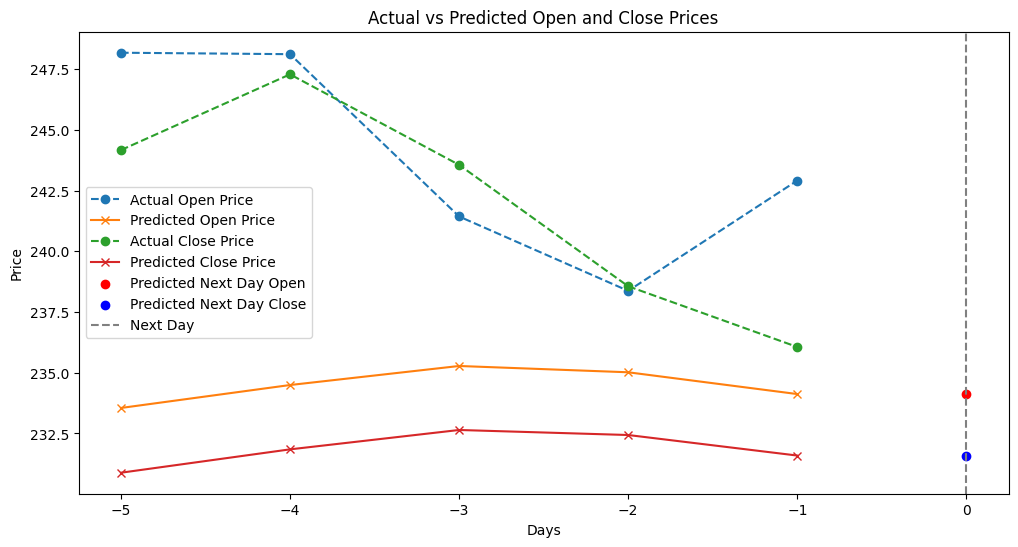

In [12]:
# Get lookback value from best parameters
lookback = best_params['lookback']
X, y = create_sequences(scaled_df.values, lookback=lookback)

# Train-test split of 80-20
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape for LSTM input (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

# Define the new model architecture with best parameters
model = Sequential()
model.add(Conv1D(filters=best_params['filters'], kernel_size=3, strides=1, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.35))
model.add(LSTM(units=best_params['lstm_units'], return_sequences=False, activation='tanh'))
model.add(Dense(units=2))  # Predicting Open and Close prices
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Train the model with best parameters
history = model.fit(X_train, y_train, epochs=best_params['epoch'], batch_size=64, validation_data=(X_test, y_test), verbose=1)

# Predict last 5 days' Open and Close prices
last_5_sequences = X_test[-5:].reshape(5, X_test.shape[1], X_test.shape[2])
y_last_5_pred = model.predict(last_5_sequences)

# Inverse transform the predicted values to original scale
predicted_last_5_days = scaler.inverse_transform(np.concatenate((y_last_5_pred, y_last_5_pred), axis=1))[:, :2]
actual_last_5_days = scaler.inverse_transform(np.concatenate((y_test[-5:], y_test[-5:]), axis=1))[:, :2]

# Predict next day's Open and Close price using the last test sequence
last_sequence = X_test[-1].reshape(1, X_test.shape[1], X_test.shape[2])  # Get last test sequence
y_next_pred = model.predict(last_sequence)

# Inverse transform the predicted values to original scale
predicted_next_day = scaler.inverse_transform(np.concatenate((y_next_pred, y_next_pred), axis=1))[:, :2]

print("Actual Last 5 Days Open and Close Prices:")
print(actual_last_5_days)
print("\nPredicted Last 5 Days Open and Close Prices:")
print(predicted_last_5_days)
print(f"\nPredicted Next Day Open and Close Prices: {predicted_next_day}")

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
dates = range(-5, 1)  # Representing last 5 days and next day
plt.plot(dates[:-1], actual_last_5_days[:, 0], label='Actual Open Price', marker='o', linestyle='dashed')
plt.plot(dates[:-1], predicted_last_5_days[:, 0], label='Predicted Open Price', marker='x')
plt.plot(dates[:-1], actual_last_5_days[:, 1], label='Actual Close Price', marker='o', linestyle='dashed')
plt.plot(dates[:-1], predicted_last_5_days[:, 1], label='Predicted Close Price', marker='x')
plt.scatter([0], predicted_next_day[:, 0], color='red', label='Predicted Next Day Open')
plt.scatter([0], predicted_next_day[:, 1], color='blue', label='Predicted Next Day Close')
plt.axvline(x=0, color='gray', linestyle='dashed', label='Next Day')
plt.xlabel('Days')
plt.ylabel('Price')
plt.title('Actual vs Predicted Open and Close Prices')
plt.legend()
plt.show()